# Forecasting with Time Series on Agricultural Commodities



### Futures Data:- Corn, Wheat, Cocoa, Coffee, Cotton, Sugar, Soybean Oil

In [227]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import norm

import seaborn as sns
%matplotlib inline

import warnings

warnings.filterwarnings('ignore')

In [228]:
#plt.rcParams['font.sans-serif'] = ['Microsoft YaHei', 'sans-serif']

In [229]:
import yfinance as yf

In [230]:
tickers = {
            "Corn": "ZC=F",
            "Wheat": "ZW=F",
            "Soybean": "ZS=F",
            "Cocoa": "CC=F",
            "Coffee": "KC=F",
            "Cotton": "CT=F",
            "Sugar": "SB=F"
           }

start_date = "2001-01-01"
end_date = "2022-12-31"

In [231]:
all_data = []

for name, ticker in tickers.items():
    print(f"Downloading data for {name} ({ticker})...")
    data = yf.download(ticker, start = start_date, end = end_date)
    data.reset_index(inplace=True)  
    data["Ticker"] = ticker  
    data["Commodity"] = name 
    all_data.append(data)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

In [232]:
df = pd.concat(all_data)
df = df[["Ticker", "Commodity", "Date", "Open", "High", "Low", "Close", "Adj Close", "Volume"]]
df

,Ticker,Commodity,Date,Open,High,Low,Close,Adj Close,Volume
0,ZC=F,Corn,2001-01-02,221.000000,221.000000,221.000000,222.500000,222.500000,1466
1,ZC=F,Corn,2001-01-16,219.000000,219.000000,217.500000,218.500000,218.500000,957
2,ZC=F,Corn,2001-01-17,216.000000,217.000000,215.500000,216.250000,216.250000,519
3,ZC=F,Corn,2001-01-18,217.500000,219.000000,217.500000,218.750000,218.750000,940
4,ZC=F,Corn,2001-01-19,218.250000,219.500000,218.000000,218.500000,218.500000,519
...,...,...,...,...,...,...,...,...,...
5510,SB=F,Sugar,2022-12-23,20.950001,21.180000,20.809999,20.980000,20.980000,33246
5511,SB=F,Sugar,2022-12-27,20.980000,20.990000,20.230000,20.320000,20.320000,44670
5512,SB=F,Sugar,2022-12-28,20.270000,20.490000,20.100000,20.160000,20.160000,49490
5513,SB=F,Sugar,2022-12-29,20.230000,20.440001,20.129999,20.290001,20.290001,26928


In [233]:
df.isnull().sum()

Ticker       0
Commodity    0
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

<Axes: xlabel='Date'>

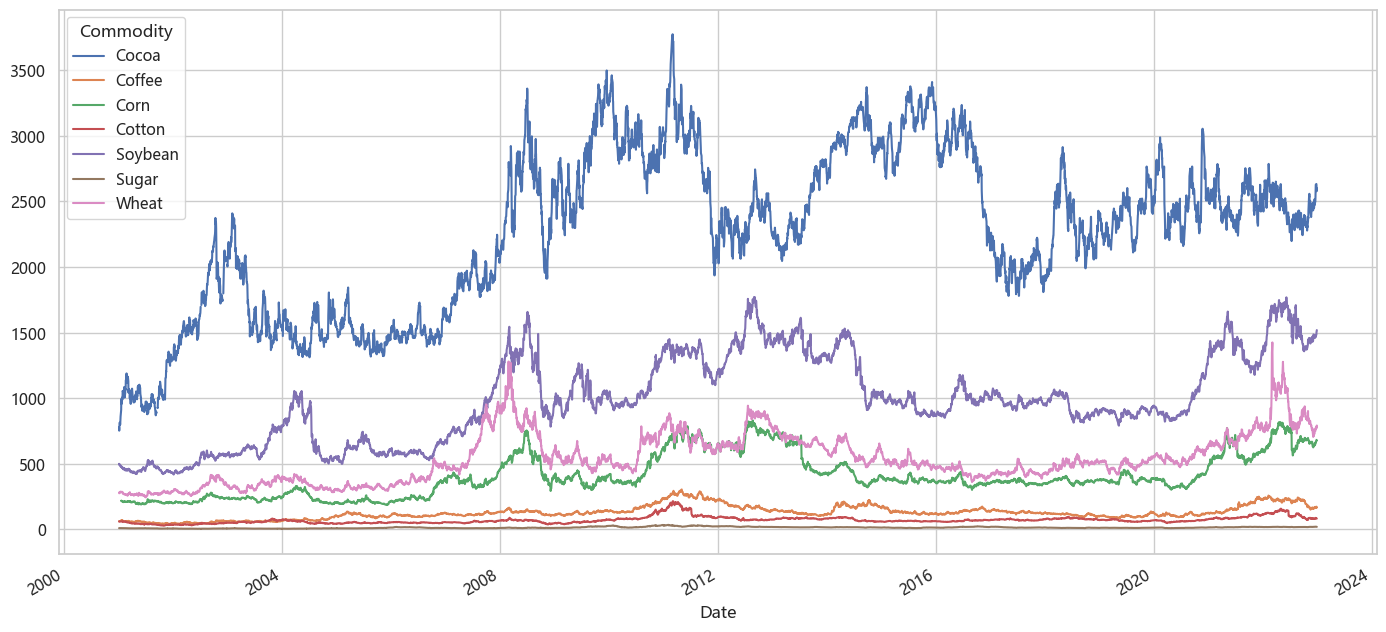

In [234]:
Daily_Closing_Prices = df[['Commodity', 'Date', 'Adj Close']]

Daily_Closing_Prices = Daily_Closing_Prices.pivot(index="Date", columns="Commodity", values="Adj Close")

Daily_Closing_Prices.plot(figsize = (17, 8))

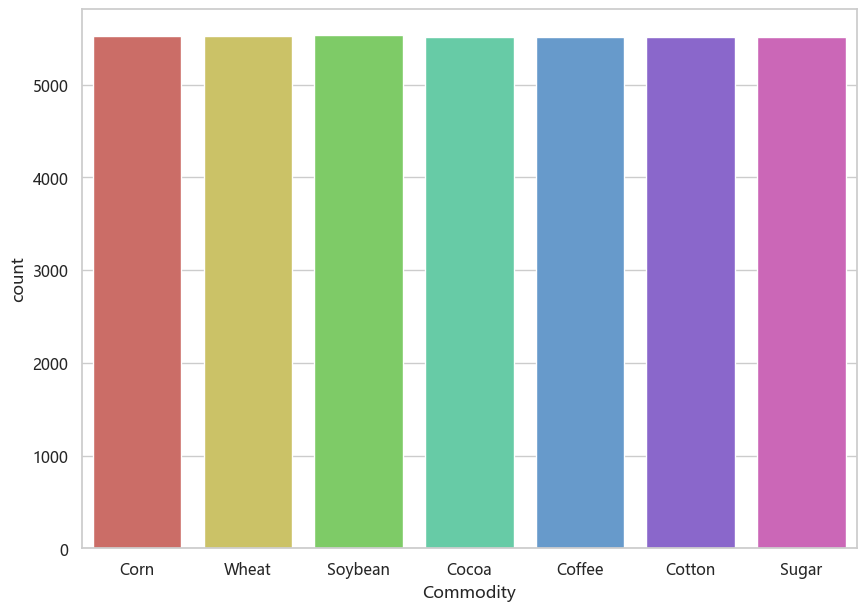

In [235]:
#HIGHEST TRADING COMMODITY
plt.figure(figsize=(10,7))
sns.countplot(x = 'Commodity', data = df, palette = 'hls')
plt.show()

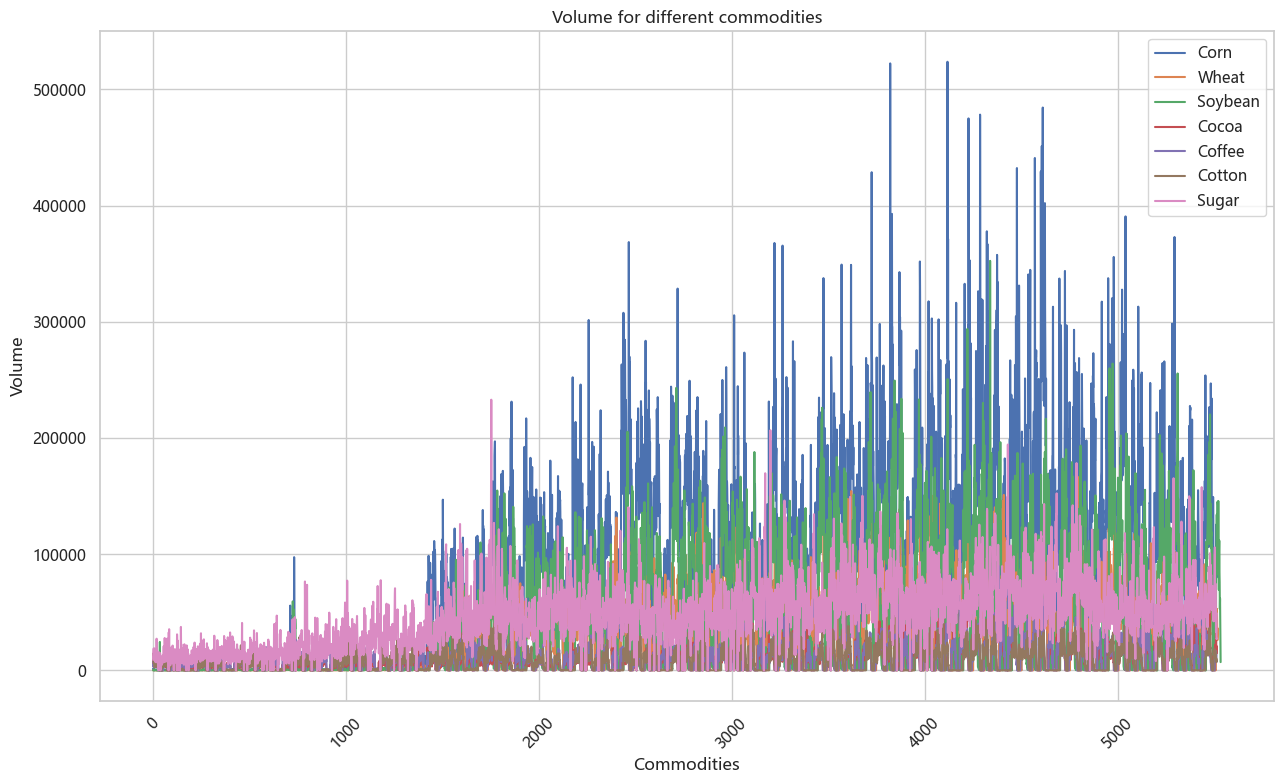

In [236]:
product = 'Commodity'
sales = 'Volume'

plt.figure(figsize=(13,8))

for i in df[product_column].unique():
    Product_data = df[df[product_column] == i]
    plt.plot(Product_data[sales_column], label = i)
    
plt.xlabel('Commodities')
plt.ylabel('Volume')
plt.title('Volume for different commodities')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [237]:
Q1 = df['Low'].quantile(0.25)
Q3 = df['Low'].quantile(0.75)
IQR = Q3 - Q1

# Define lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter DataFrame based on the bounds
df = df[(df['Low'] >= lower_bound) & (df['Low'] <= upper_bound)]

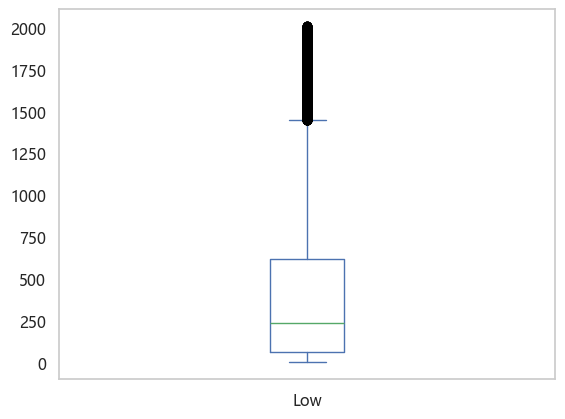

In [238]:
df['Low'].plot(kind='box')
plt.grid(False)

#### Part 1 Price Forecasting with ARIMA, SARIMAX AND LSTM

In [239]:
# import ARIMA model
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

In [240]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [241]:
# Feature engineering: Create lag features
df['lag1'] = df['Close'].shift(1)
df['lag2'] = df['Close'].shift(2)

# Train-test split
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]

# ARIMA model
# Adjust order based on grid search
model = ARIMA(train['Adj Close'], order=(1,1,1))
fit_model = model.fit()

# Forecast
forecast = fit_model.forecast(steps = len(test))

# Evaluate model performance
mse = mean_squared_error(test['Adj Close'], forecast)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 3005.529114564774


In [242]:
# Resample to monthly frequency 
non_numeric_cols = df[['Commodity', 'Ticker']]

numeric_resampled = df.select_dtypes(include='number').drop(columns=['lag1', 'lag2']).resample('M').mean()

non_numeric_resampled = non_numeric_cols.resample('M').first()

df_resampled = pd.concat([non_numeric_resampled, numeric_resampled], axis=1)


In [243]:
# Feature engineering: Create lag features
df_resampled['lag1'] = df_resampled['Adj Close'].shift(1)
df_resampled['lag2'] = df_resampled['Adj Close'].shift(2)

# Train-test split
train_size = int(len(df_resampled) * 0.8)
train, test = df_resampled[:train_size], df_resampled[train_size:]

# ARIMA model
model = ARIMA(train['Adj Close'], order=(1,1,1))
fit_model = model.fit()

# Forecast
forecast = fit_model.forecast(steps=len(test))

# Evaluate model performance
mse = mean_squared_error(test['Adj Close'], forecast)
mse

17483.115735701474

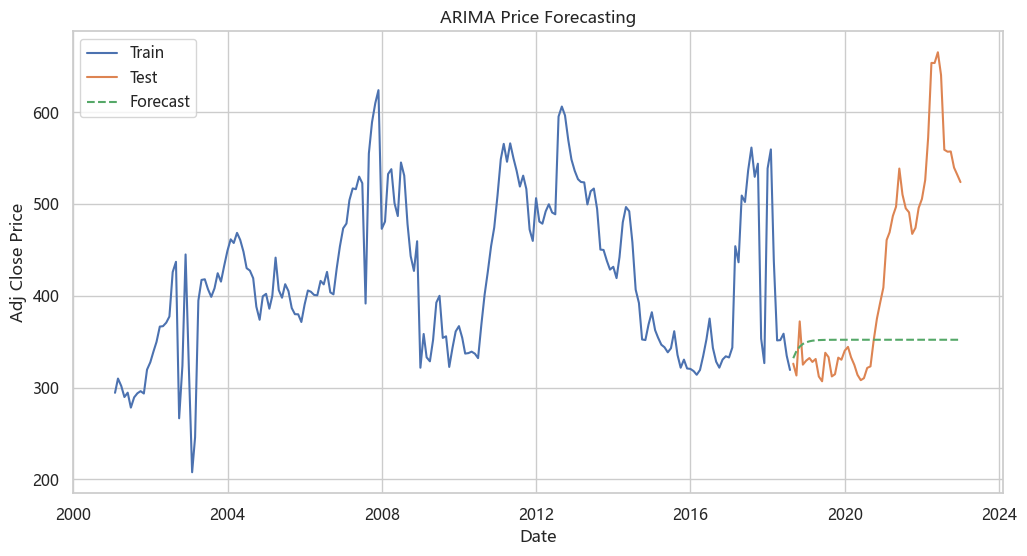

In [244]:
# Plot actual vs. forecasted
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Adj Close'], label='Train')
plt.plot(test.index, test['Adj Close'], label='Test')
plt.plot(test.index, forecast, label='Forecast', linestyle='dashed')
plt.title('ARIMA Price Forecasting')
plt.xlabel('Date')
plt.ylabel('Adj Close Price')
plt.legend()
plt.show()

#### ADF Test to test whether a given Time series is stationary or not

In [245]:
from statsmodels.tsa.stattools import adfuller

In [246]:
test_result = adfuller(df['Adj Close'])

In [247]:
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(i):
    result = adfuller(i)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result, labels):
        print(label + ' : ' + str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(H_0), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [248]:
adfuller_test(df['Adj Close'])

ADF Test Statistic : -3.0925950658753543
p-value : 0.02710606223802288
#Lags Used : 52
Number of Observations Used : 34879
strong evidence against the null hypothesis(H_0), reject the null hypothesis. Data has no unit root and is stationary


In [249]:
df['Seasonal First Difference'] = df['Adj Close'] - df['Adj Close'].shift(12)

adfuller_test(df['Seasonal First Difference'].dropna())

ADF Test Statistic : -23.490686167689294
p-value : 0.0
#Lags Used : 52
Number of Observations Used : 34867
strong evidence against the null hypothesis(H_0), reject the null hypothesis. Data has no unit root and is stationary


<Axes: xlabel='Date'>

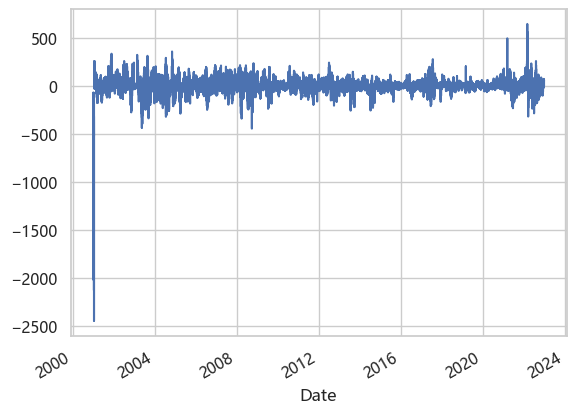

In [250]:
df['Seasonal First Difference'].plot()

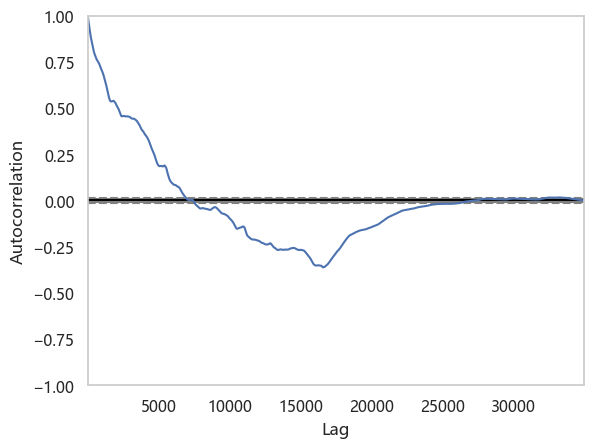

In [251]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(df['Adj Close'])
plt.show()

In [252]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm

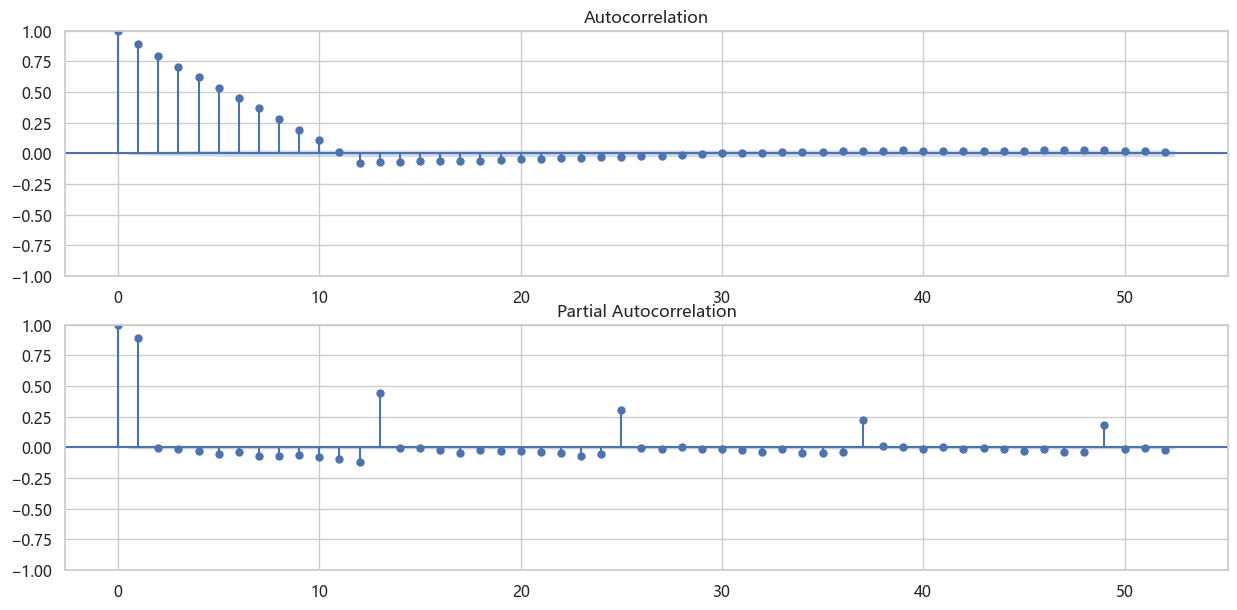

In [253]:
fig = plt.figure(figsize = (15,7))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['Seasonal First Difference'].iloc[13:], lags = 52, ax = ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['Seasonal First Difference'].iloc[13:], lags = 52, ax = ax2)

- Since the time series data is stationary, so implementing Seasonal Autoregressive Integrated Moving Average with SARIMAX model for seasonal data

In [254]:
model = sm.tsa.statespace.SARIMAX(df['Adj Close'], order = (1, 1, 1), seasonal_order = (1, 1, 1, 12))
results = model.fit()

- Seasonal Trend: trend, season and residual

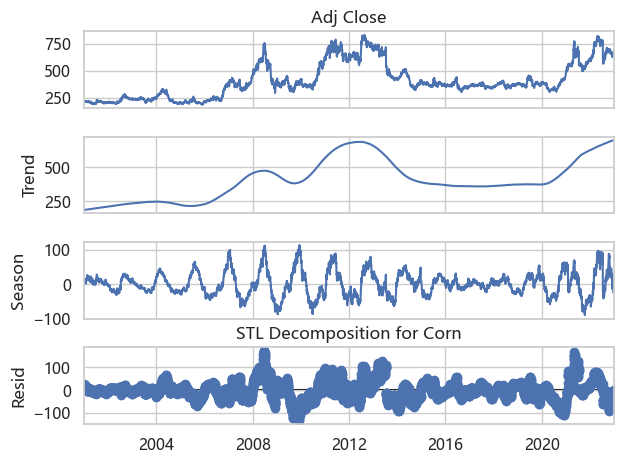

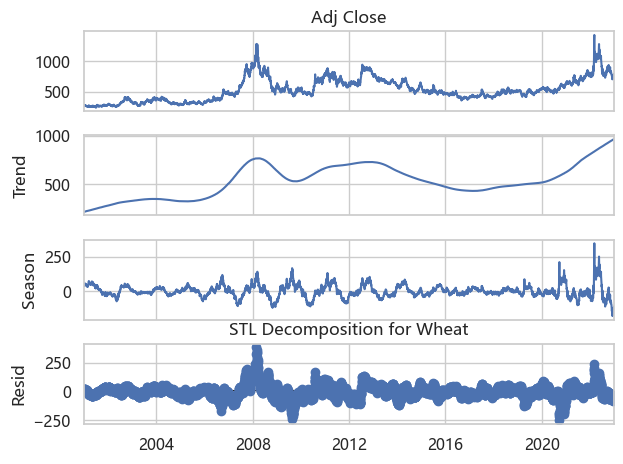

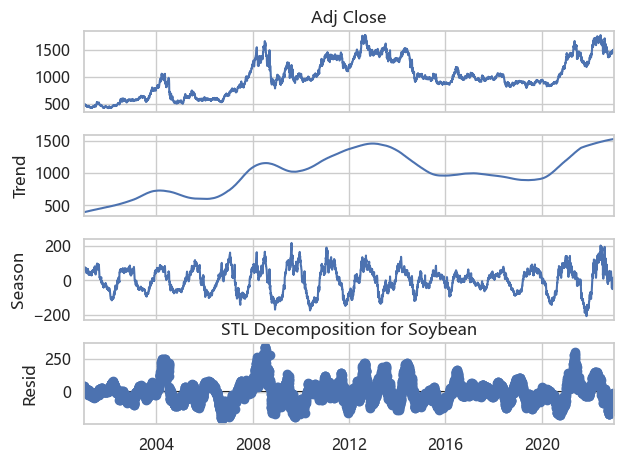

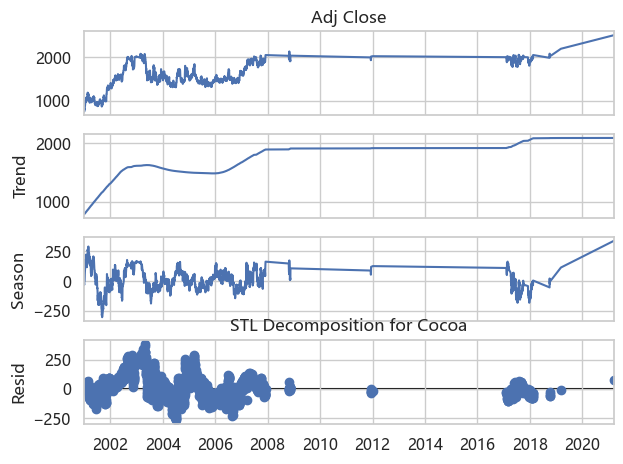

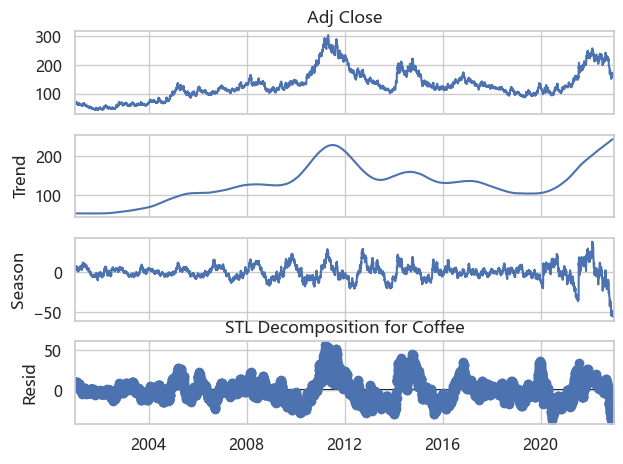

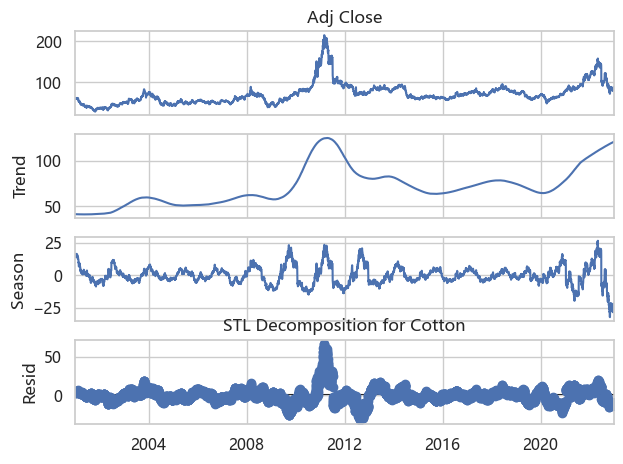

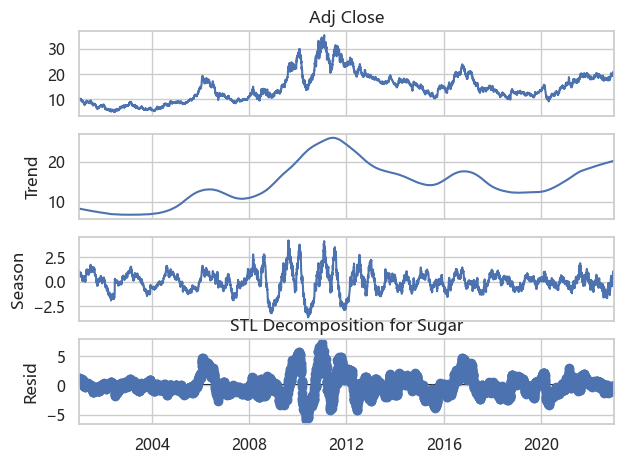

In [255]:
from statsmodels.tsa.seasonal import STL

commodities = df['Commodity'].unique()

for i in commodities:
    commodity_data = df[df['Commodity'] == i]
    
    commodity_data = commodity_data.sort_index()

    period = 365
    
    stl_result = STL(commodity_data['Adj Close'], period = period).fit()

    stl_result.plot()
    plt.title(f'STL Decomposition for {i}') 
    plt.show()

- Plot adjusted price for each Agricultural commodity

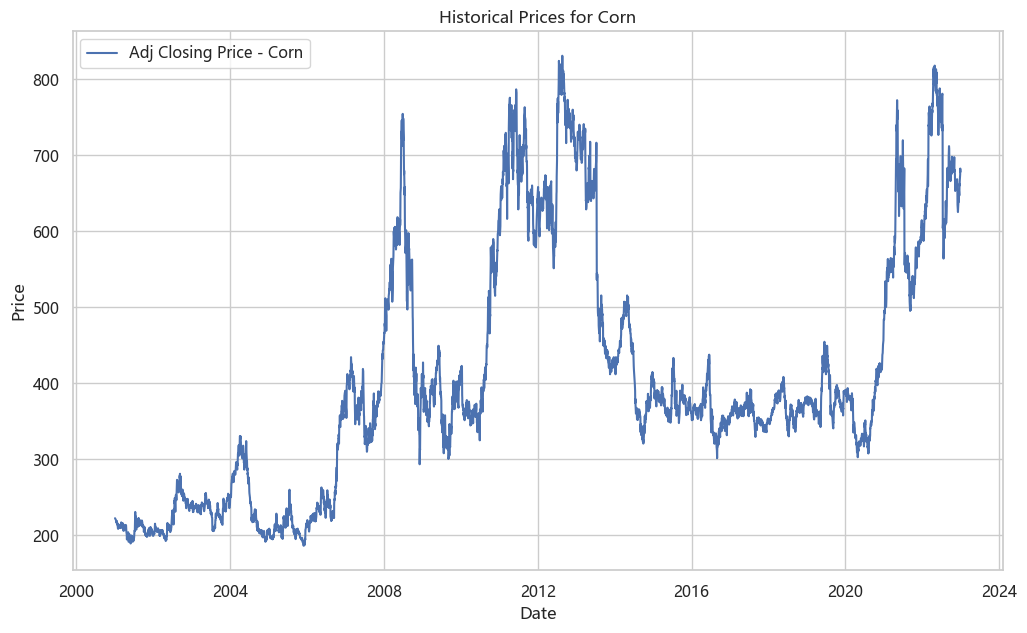

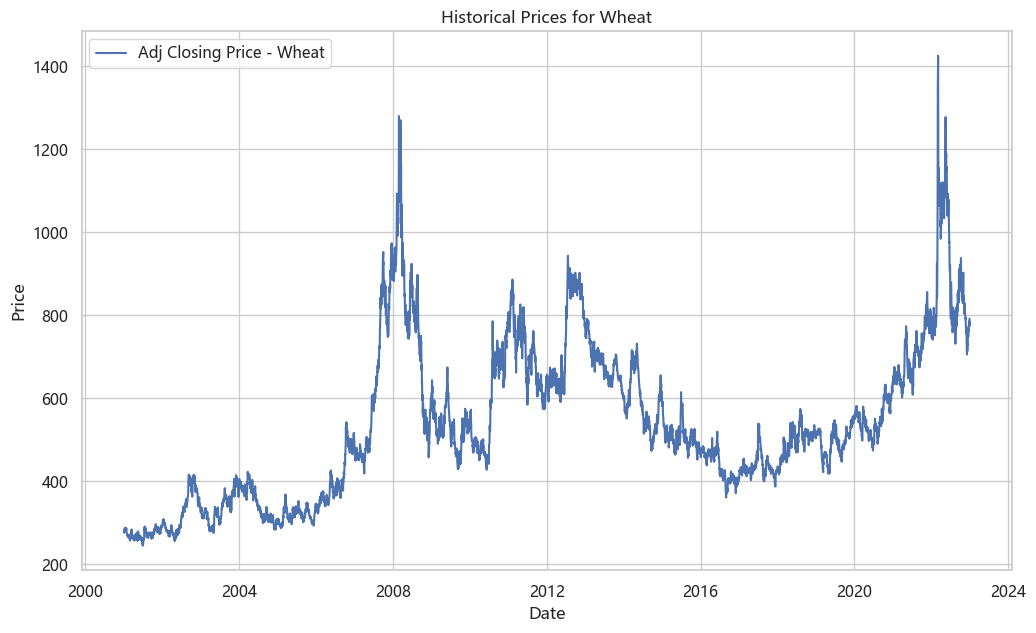

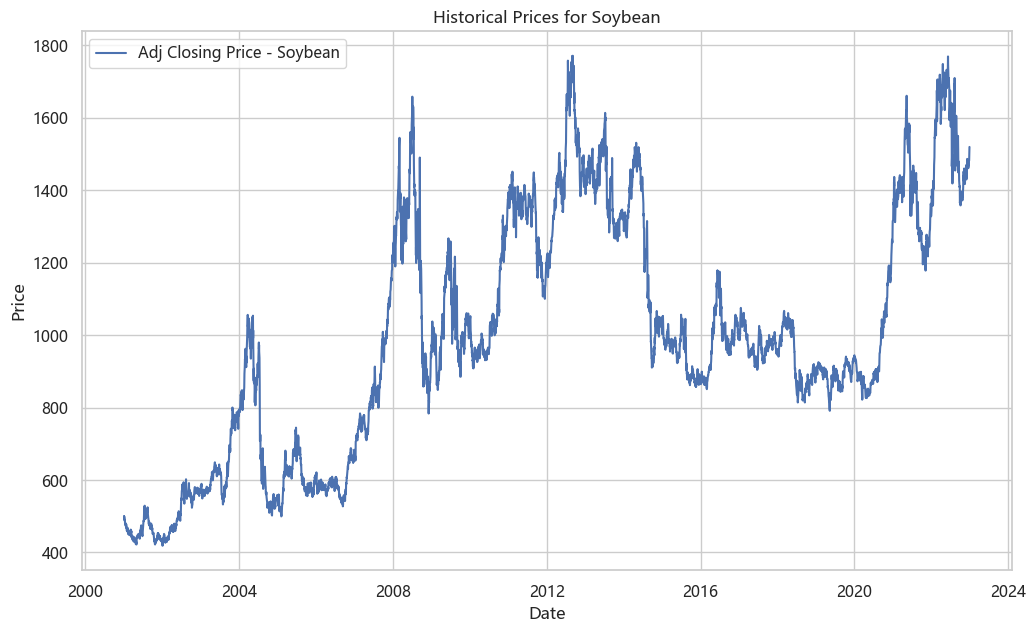

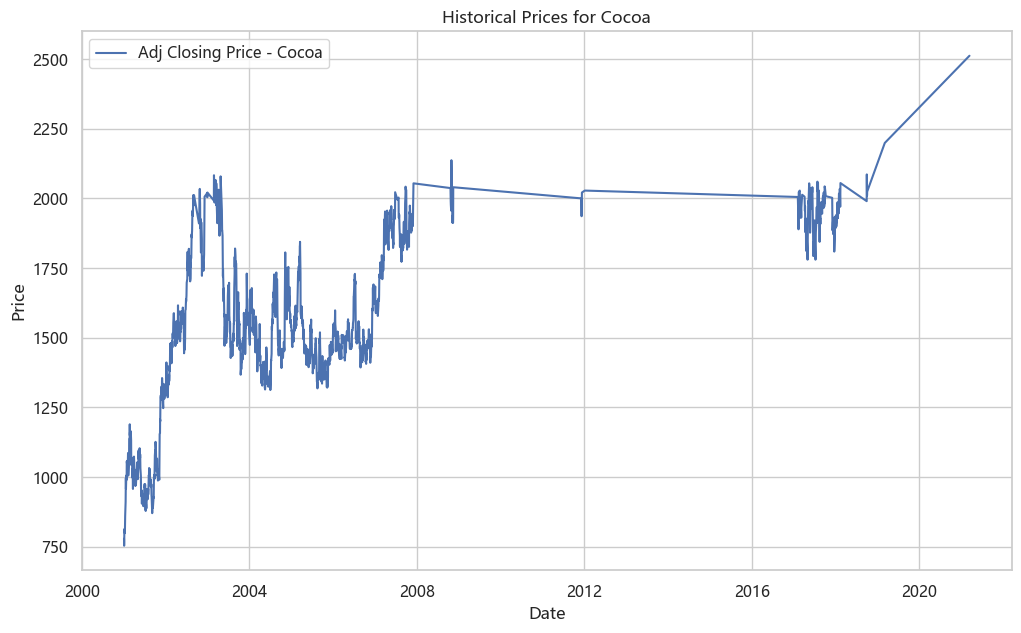

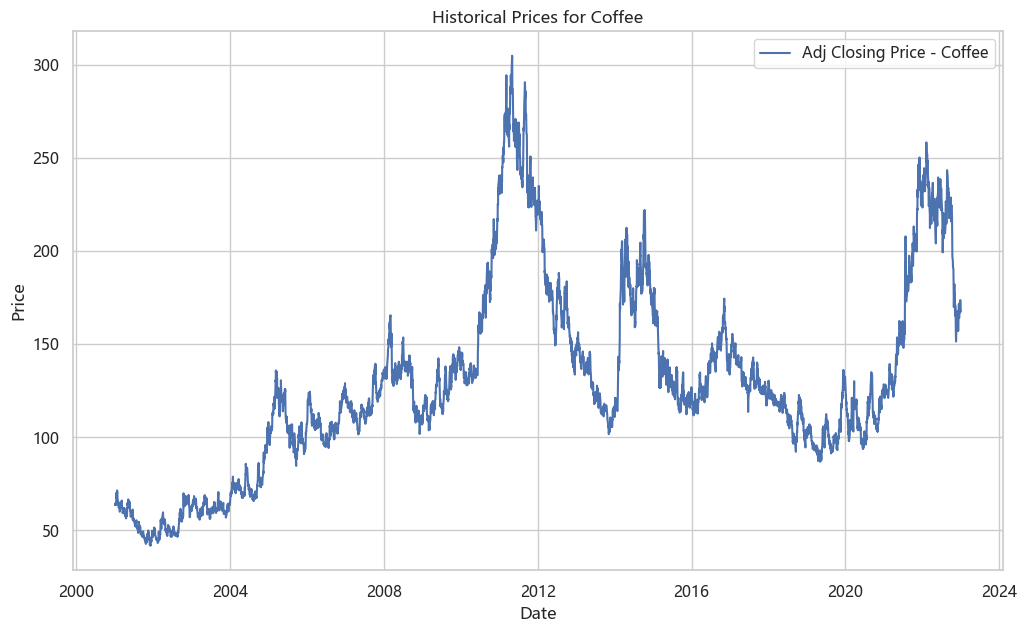

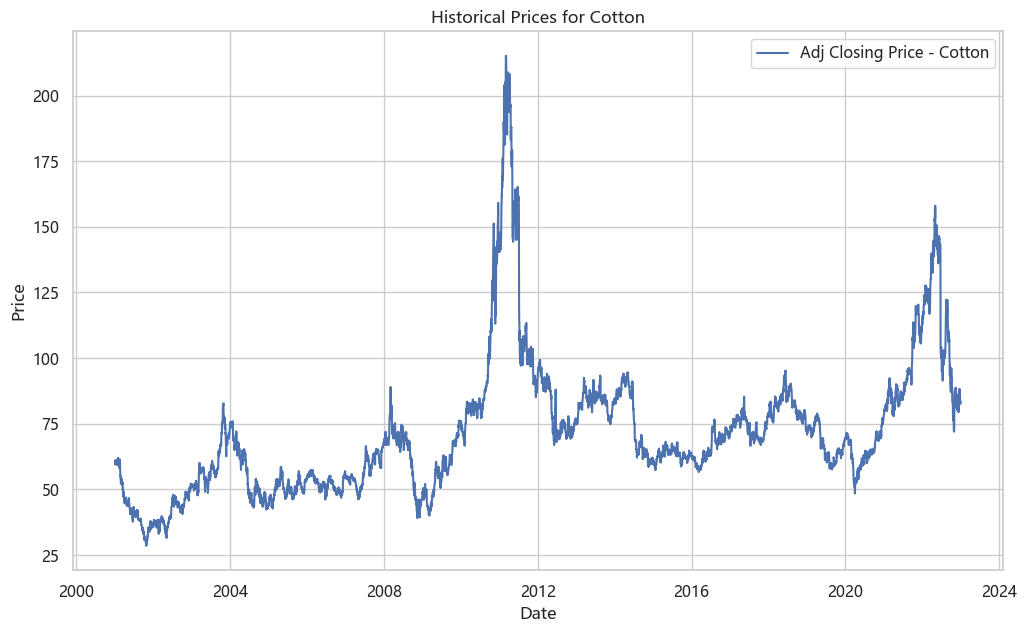

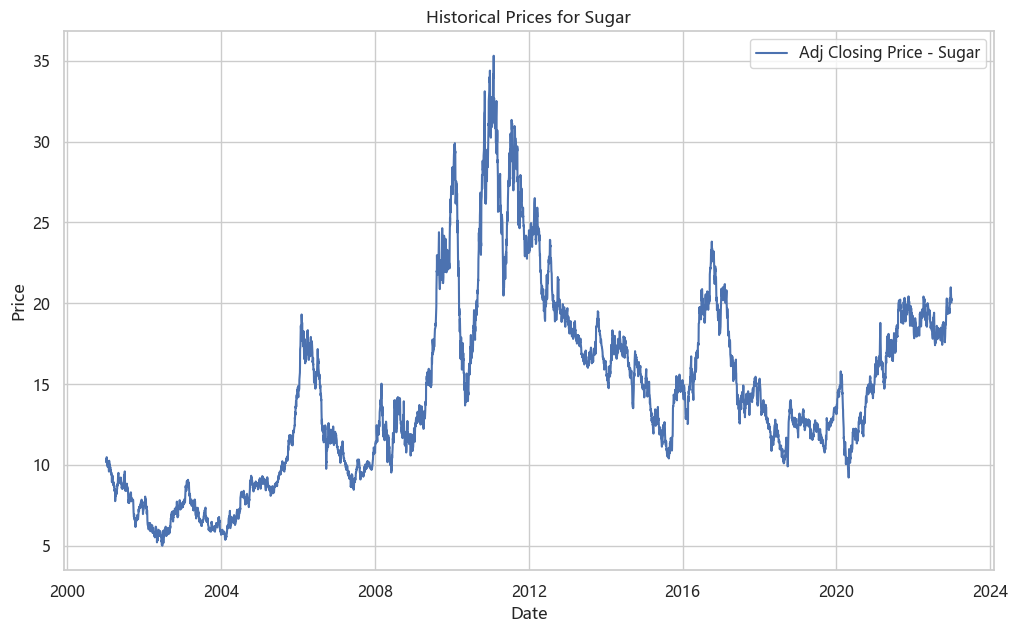

In [257]:
commodities = df['Commodity'].unique()

for i in commodities:
    commodity_data = df[df['Commodity'] == i]
    
    # Plot closing prices for the current commodity
    plt.figure(figsize = (12, 7))
    plt.plot(commodity_data.index, commodity_data['Adj Close'], label = f'Adj Closing Price - {i}')
    plt.title(f'Historical Prices for {i}')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

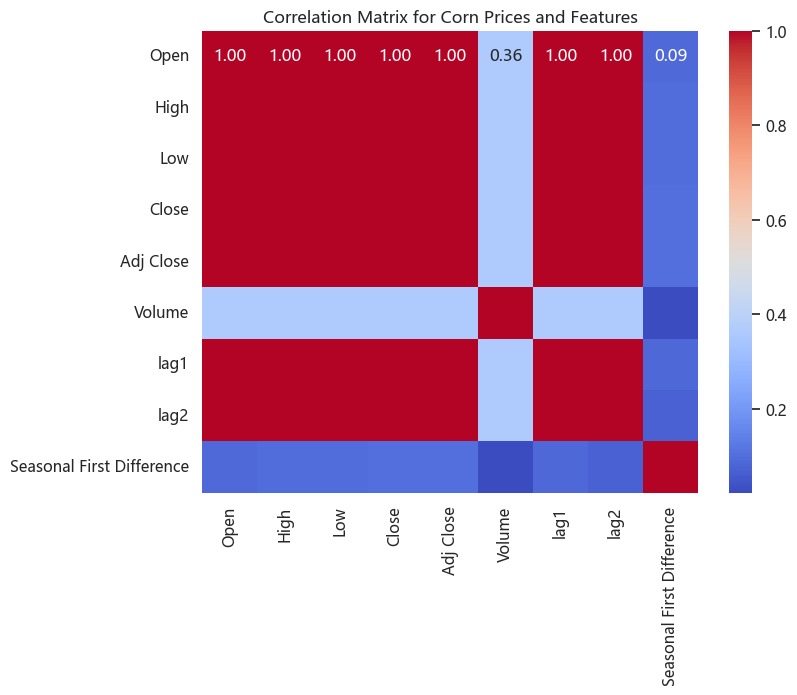

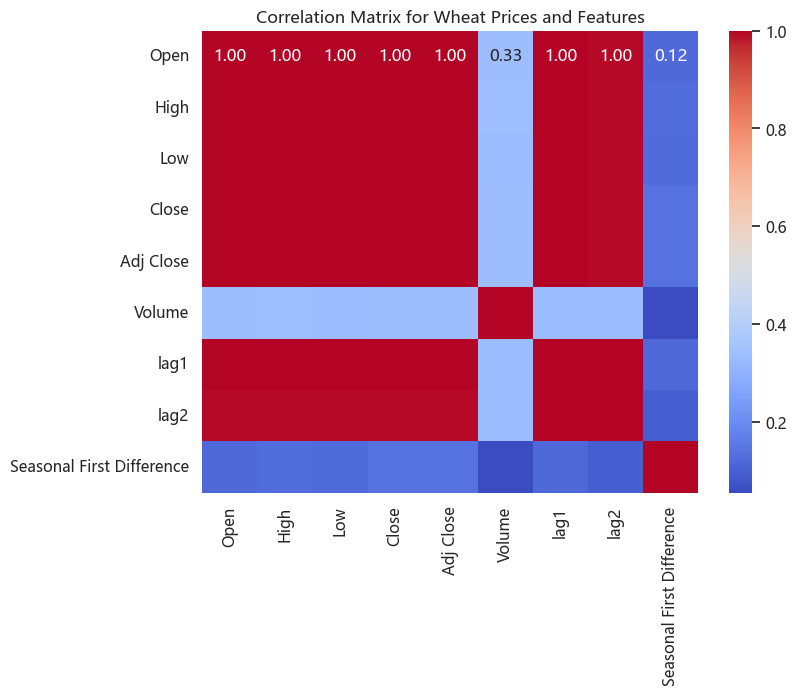

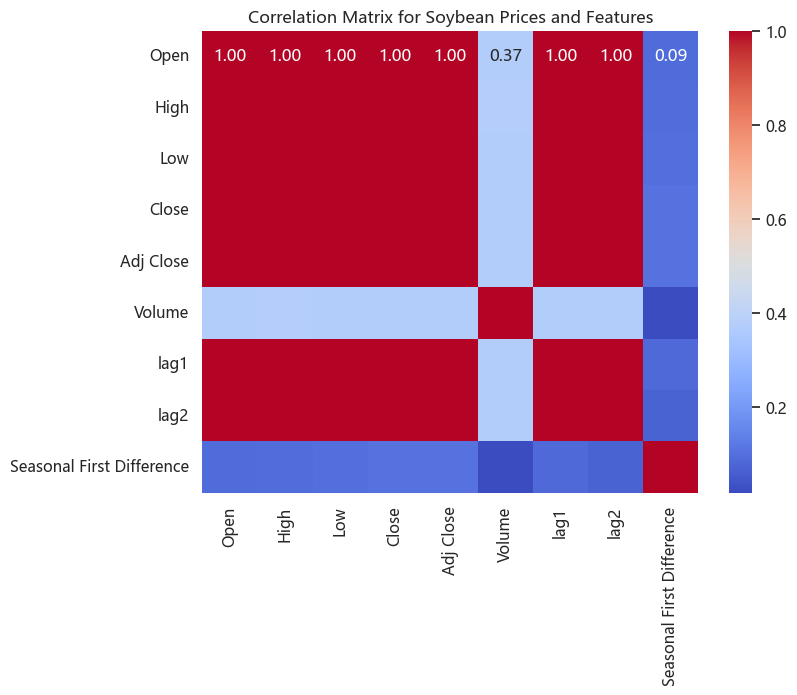

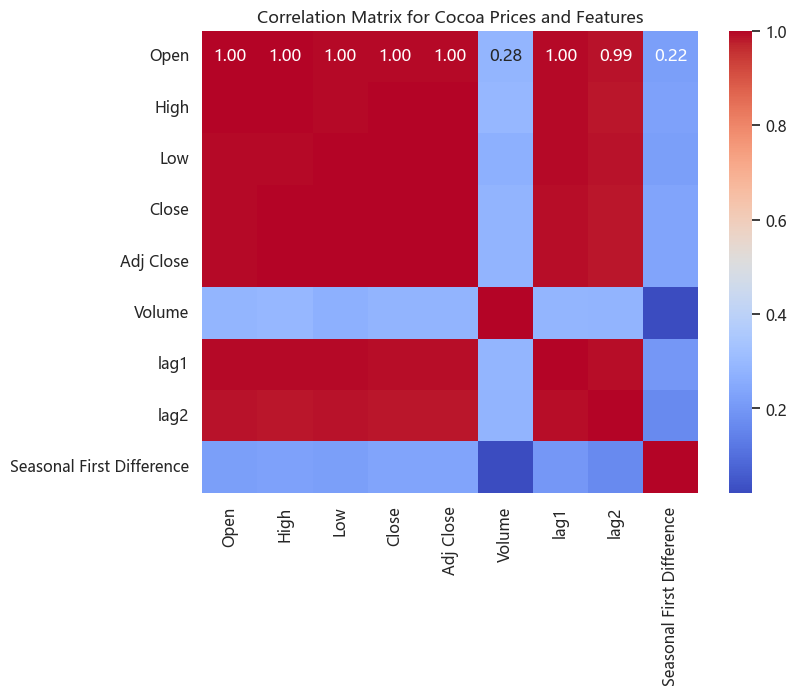

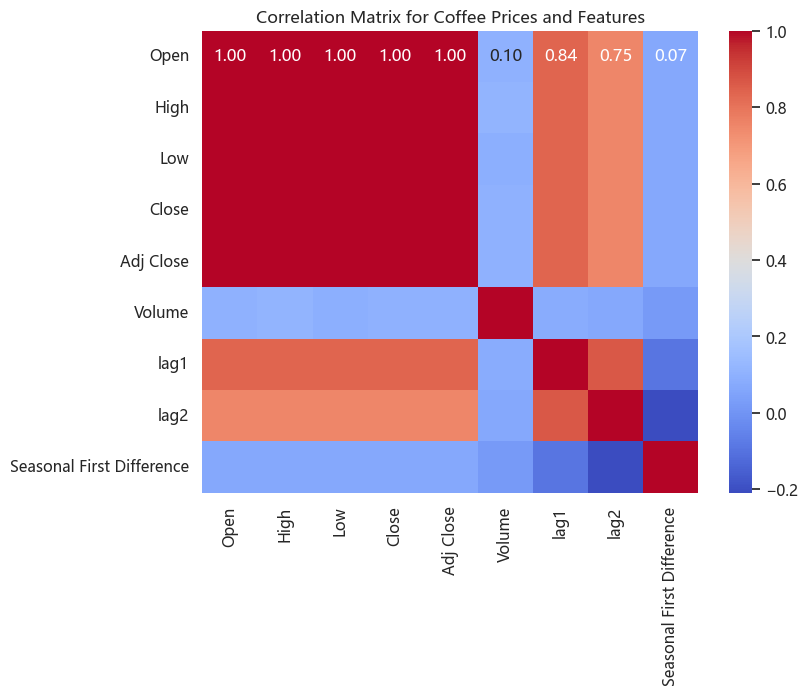

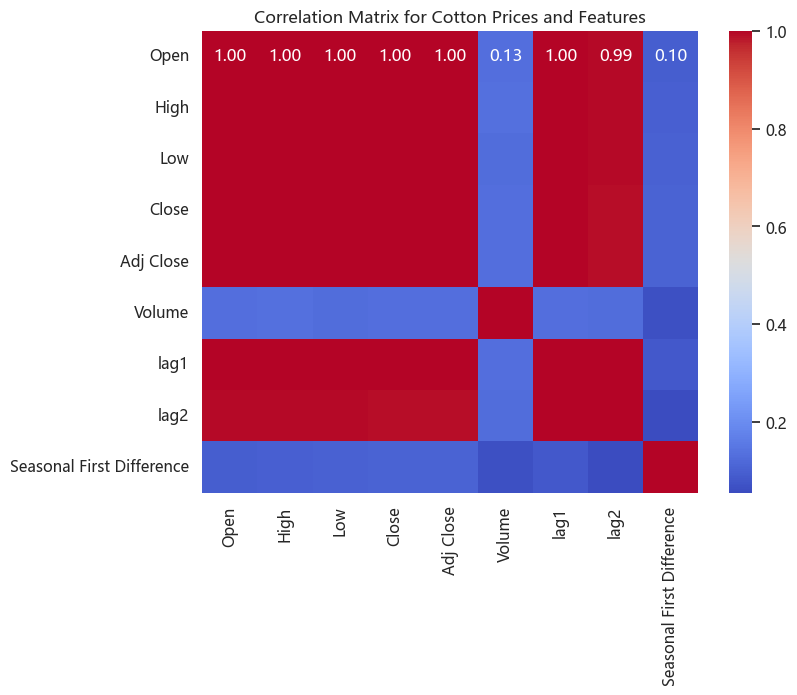

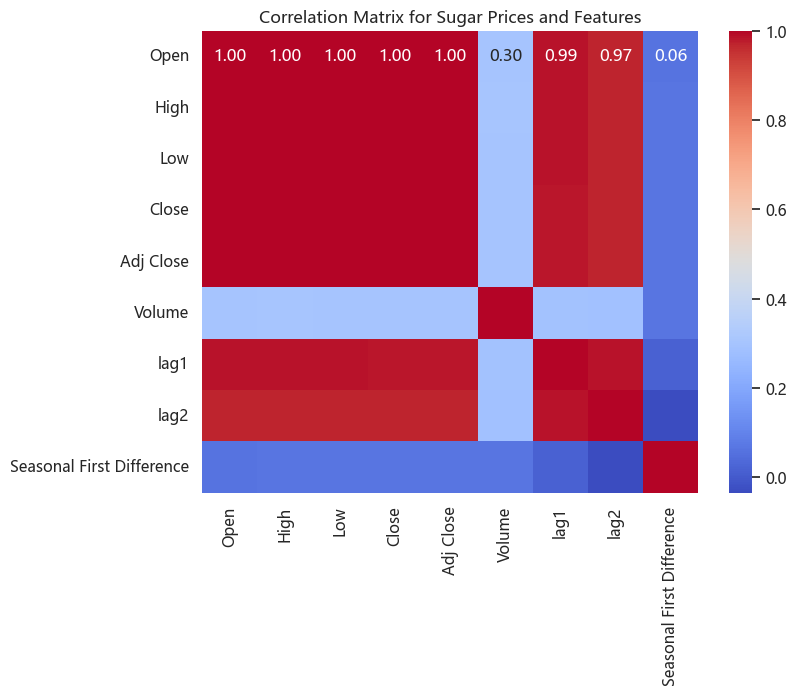

In [258]:
commodities = df['Commodity'].unique()

# Calculate and visualize correlation coefficients for each commodity
for i in commodities:
    commodity_data = df[df['Commodity'] == i]
    numeric_data = commodity_data.select_dtypes(include='number')
    correlations = numeric_data.corr()
    
    plt.figure(figsize = (8, 6))
    sns.heatmap(correlations, annot = True, cmap='coolwarm', fmt = ".2f")
    plt.title(f'Correlation Matrix for {i} Prices and Features')
    plt.show()

### LSTM

In [259]:
from sklearn.preprocessing import MinMaxScaler

- Take Corn as an example

In [260]:
commodity_data = df[df['Commodity'] == 'Corn']
target_variable = 'Adj Close'

# Extract the target variable and normalize
data = commodity_data[target_variable].values.reshape(-1, 1)
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Convert the time series data into sequences
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data[i : i + seq_length]
        sequences.append(seq)
    return np.array(sequences)

seq_length = 10  
X = create_sequences(data_scaled, seq_length)
y = data_scaled[seq_length:]

# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [261]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential()
model.add(LSTM(units = 50, activation = 'relu', input_shape = (seq_length, 1)))
model.add(Dense(units = 1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

y_pred = model.predict(X_test)
y_pred_original = scaler.inverse_transform(y_pred)
y_test_original = scaler.inverse_transform(y_test)

# Calculate evaluation metrics (e.g., MAE, MSE)
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test_original, y_pred_original)
mse = mean_squared_error(y_test_original, y_pred_original)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step 
Mean Absolute Error: 313.6915063598411
Mean Squared Error: 120617.23334885875


In [262]:
data = commodity_data[[target_variable]].values

scaler = MinMaxScaler(feature_range = (0, 1))
scaled_data = scaler.fit_transform(data)

train_size = int(len(scaled_data) * 0.8)
train, test = scaled_data[:train_size], scaled_data[train_size:]


def create_sequences(data, sequence_length):
    sequences = []
    for i in range(len(data) - sequence_length):
        seq = data[i:i + sequence_length]
        sequences.append(seq)
    return np.array(sequences)

sequence_length = 10 


train_sequences = create_sequences(train, sequence_length)


model = Sequential()
model.add(LSTM(units = 50, return_sequences=True, input_shape = (train_sequences.shape[1], 1)))
model.add(LSTM(units = 50))
model.add(Dense(units = 1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')


model.fit(train_sequences, train[sequence_length:], epochs=100, batch_size = 32)

test_sequences = create_sequences(test, sequence_length)

predictions = model.predict(test_sequences)

predictions = scaler.inverse_transform(predictions)
test_original = scaler.inverse_transform(test[sequence_length:])

Epoch 1/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0178
Epoch 2/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8.3847e-04
Epoch 3/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.4967e-04
Epoch 4/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.8714e-04
Epoch 5/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.3813e-04
Epoch 6/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.0501e-04
Epoch 7/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.8047e-04
Epoch 8/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.5971e-04
Epoch 9/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.2433e-04
Epoch 10/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.0167e-04
Epoch 11/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.3115e-04
Epoch 12/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.4314e-04
Epoch 13/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4.1034e-04
Epoch 14/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.

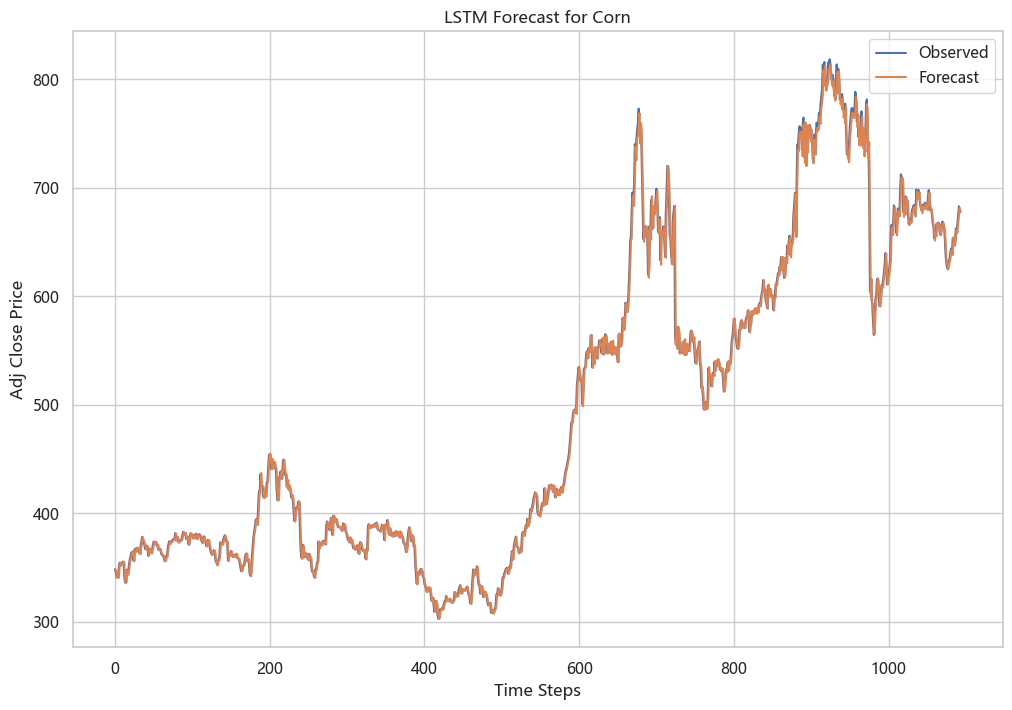

In [263]:
plt.figure(figsize = (12, 8))
plt.plot(test_original, label = 'Observed')
plt.plot(predictions, label = 'Forecast')
plt.title('LSTM Forecast for Corn')
plt.xlabel('Time Steps')
plt.ylabel('Adj Close Price')
plt.legend()
plt.show()

In [264]:
# Demand Forecast
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month
df['season'] = (df.index.month % 12 + 3) // 3 
df['lag1'] = df['Adj Close'].shift(1)  
df['lag2'] = df['Adj Close'].shift(2) 

In [265]:
df

,Ticker,Commodity,Open,High,Low,Close,Adj Close,Volume,lag1,lag2,Seasonal First Difference,day_of_week,month,season
Date,,,,,,,,,,,,,,
2001-01-02,ZC=F,Corn,221.000000,221.000000,221.000000,222.500000,222.500000,1466,NaN,NaN,NaN,1,1,1
2001-01-16,ZC=F,Corn,219.000000,219.000000,217.500000,218.500000,218.500000,957,222.500000,NaN,NaN,1,1,1
2001-01-17,ZC=F,Corn,216.000000,217.000000,215.500000,216.250000,216.250000,519,218.500000,222.500000,NaN,2,1,1
2001-01-18,ZC=F,Corn,217.500000,219.000000,217.500000,218.750000,218.750000,940,216.250000,218.500000,NaN,3,1,1
2001-01-19,ZC=F,Corn,218.250000,219.500000,218.000000,218.500000,218.500000,519,218.750000,216.250000,NaN,4,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,SB=F,Sugar,20.950001,21.180000,20.809999,20.980000,20.980000,33246,20.889999,20.750000,1.500000,4,12,1
2022-12-27,SB=F,Sugar,20.980000,20.990000,20.230000,20.320000,20.320000,44670,20.980000,20.889999,0.639999,1,12,1
2022-12-28,SB=F,Sugar,20.270000,20.490000,20.100000,20.160000,20.160000,49490,20.320000,20.980000,0.559999,2,12,1


In [266]:
# Demand for Corn using LSTM
import tensorflow as tf
from tensorflow.keras.layers import Dropout

commodity_data = df[df['Commodity'] == 'Corn']

features = ['Open', 'High', 'Low', 'Adj Close', 'Volume']
target_variable = 'Adj Close'

selected_columns = features + [target_variable]

data = commodity_data[selected_columns]

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

seq_length = 10

X, y = [], []
for i in range(len(scaled_data) - seq_length):
    X.append(scaled_data[i:i+seq_length, :-1])  
    y.append(scaled_data[i+seq_length, -1])

X, y = np.array(X), np.array(y)

In [267]:
model = Sequential()
model.add(Dropout(0.2))

model.add(LSTM(units=100, activation='sigmoid', input_shape=(seq_length, X.shape[2]), return_sequences=True))

model.add(LSTM(units=100, activation='sigmoid', return_sequences=True))

model.add(LSTM(units=100, activation='sigmoid'))

model.add(Dense(units=1,activation='linear'))
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X, y, epochs=100, batch_size=32)

Epoch 1/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.1216
Epoch 2/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0090
Epoch 3/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0024
Epoch 4/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0021
Epoch 5/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0023
Epoch 6/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0027
Epoch 7/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0022
Epoch 8/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0020
Epoch 9/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0019
Epoch 10/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0019
Epoch 11/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0021
Epoch 12/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0021
Epoch 13/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0022
Epoch 14/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0020
Epoch 15/100
173/173 ━━━━━━━━

In [268]:
# Suppose the future periods to forecast: n
n = 5

future_dates = pd.date_range(start = df.index[-1], periods = n+1, freq = 'B')[1:]

future_data = pd.DataFrame(index = future_dates, columns = features)

future_data.fillna(0, inplace = True)

In [269]:
scaled_future_data = scaler.transform(future_data[features + [target_variable]])
scaled_future_data = scaled_future_data.reshape((1, len(features) + 1, n))

In [270]:
future_predictions = model.predict(scaled_future_data)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


In [271]:
min_target = scaler.data_min_[-1]
max_target = scaler.data_max_[1]

In [272]:
future_predictions_original = future_predictions * (max_target - min_target) + min_target

In [273]:
future_demand_df = pd.DataFrame(index = future_dates, columns = ['Demand'])

In [274]:
future_demand_df['Demand'] = future_predictions_original.squeeze()

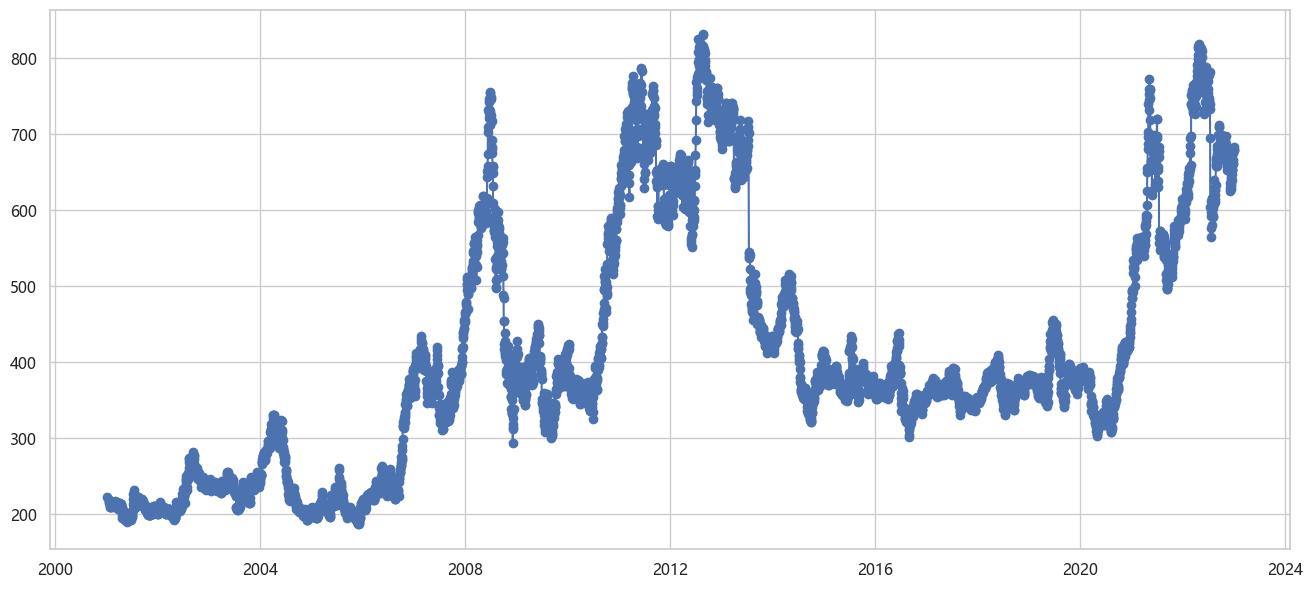

In [275]:
observed_data = df[df['Commodity'] == 'Corn']['Adj Close']

plt.figure(figsize = (16,7))
plt.plot(observed_data, label = 'Observed', marker = 'o')

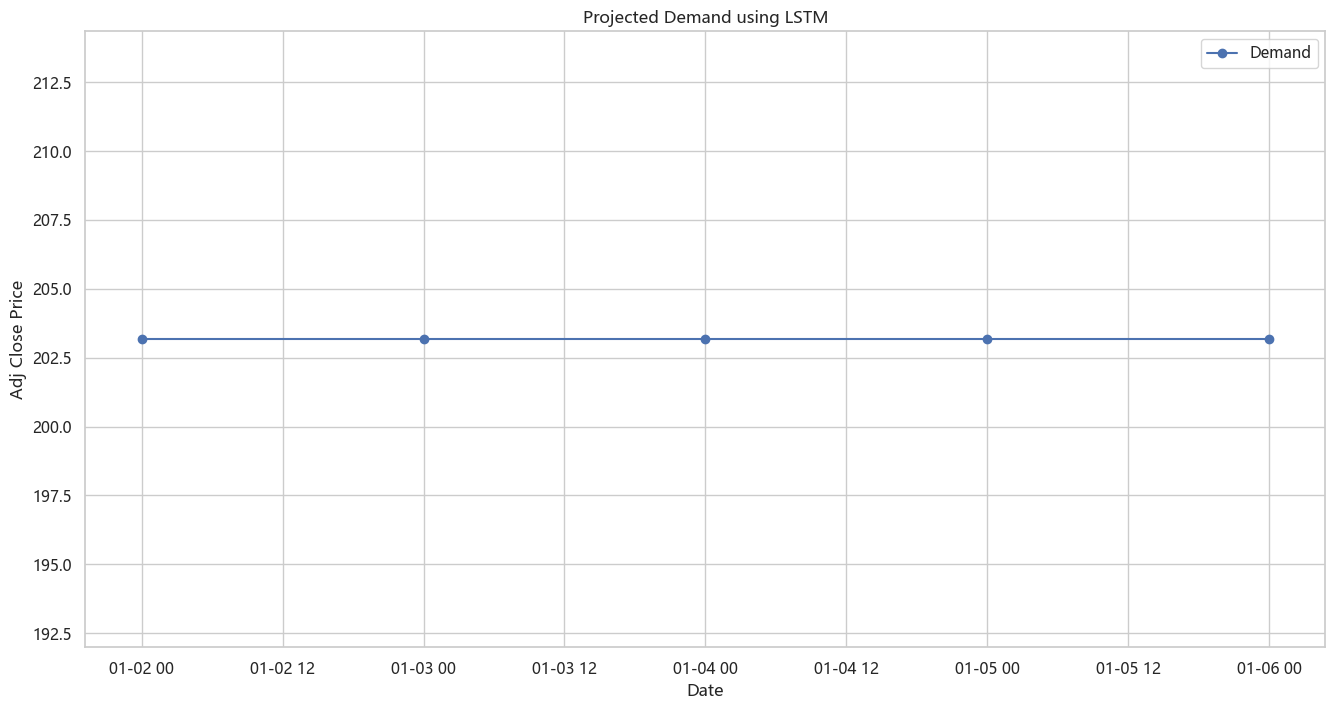

In [276]:
plt.figure(figsize = (16, 8))
plt.plot(future_demand_df.index, future_demand_df['Demand'], label='Demand', marker='o')
plt.title('Projected Demand using LSTM')
plt.xlabel('Date')
plt.ylabel('Adj Close Price')
plt.legend()
plt.show()